# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
Задача - построить модель, которая умеет определять рыночную стоимость автомобиля по его характеристикам. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
качество предсказания;
время обучения модели;
время предсказания модели.
Данные находятся в файле autos.csv.
Для оценки качества моделей целевая метрика RMSE, целевое значение RMSE  не ниже 2500.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Изучим данные датасета на наличие пропусков и дубликатов. Оценим типы переменных, аномалии и полезность признаков для последующих предсказаний целевого признака - стоимости авто.**

In [2]:
data = pd.read_csv('/content/drive/My Drive/projects/car_price_prediction/autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Из информации выше можем сделать вывод, что следующие признаки не будут информативны для предсказаний целевого признака с точки зрения логики: `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`,`LastSeen`.**

**Т.к в данном случае у нас просто выгрузка из БД, при этом нет понимания, была ли продана каждая из данных машин по указанной в анкете цене или нет. Количество фотографий для каждой из анкет равно 0, что тоже очень странно. Будем считать, что все данные авто были проданы по указанной в анкете цене и она была последней на момент снятия объявления в связи с успешной продажей.**

**В реальной ситуации необходимо было бы уточнить у коллег, ответственных за выгрузку этих данных, так ли это на самом деле. И если не так, то выгрузить анкеты, которые относятся к проданным авто по указанной в анкете стоимости.**


**Удалим ниже неинформативные признаки.**

**Также видим, что есть аномальные значения в следующих признаках:**

**`RegistrationYear` - значения ниже 1960 вплоть до 1000 года и выше 2023 года;**

**`Price` - слишком низкие значения вплоть до 0;**

**`RegistrationMonth` - значения 0.**

**`Power` - значения 0 и очень высокие значения, вплоть до 20000 л.с.**

**Необходимо будет подробнее проанализировать данные признаки на кол-во таких аномальных значений.**

In [5]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


**Посмотрим, какое кол-во объектов признака год выпуска попадает в диапазон ниже 1970 года и выше 2023 года.**

In [6]:
initial_rows = data.shape[0]
data[
    (1970 > data['RegistrationYear']) | (2023 < data['RegistrationYear'])
    ]['RegistrationYear'].count() / data.shape[0]

0.0040720266163236625

**Около 0.4%. В эти диапазоны попадают либо ошибочные данные, либо редкие раритетные модели автомобилей. Поэтому отфильтруем данные значение из исходных данных.**

In [7]:
data = data[(1970 <= data['RegistrationYear']) & (data['RegistrationYear'] <= 2023)]
data.shape[0] / initial_rows

0.9959279733836763

**Осталось более 99,5% данных после удаления.**

**Проверим теперь значения признака `Price` подробнее. Воспользуемся сначала диаграммой boxplot.**

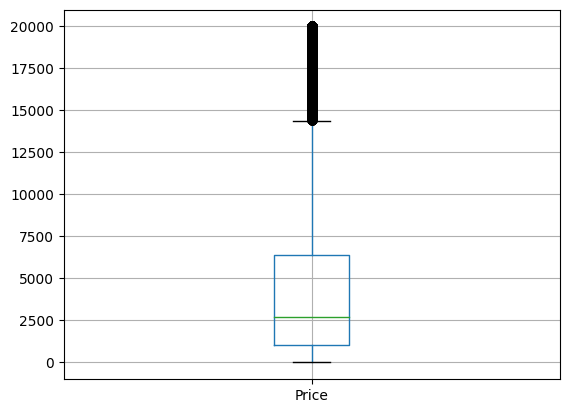

In [8]:
plt.ylim([-1000,21000])
data.boxplot(column='Price');

**Несмотря на то, что значения выше 15000 попадают вне верхнего диапазона диаграммы и значение 0 входит в нижний диапазон, мы не можем отбросить верхние значения c точки зрения здравого смысла, т.к. 20000 евро адекватная цена для авто. Необходимо найти ту грань нижнего диапазона, начиная от которой необходимо будет отбросить данные значения, т.к. они не отражают реальную стоимость.**

**Дополнительно проверим, какой процент данных содержит нулевую стоимость.**

In [9]:
data[(2010 < data['RegistrationYear']) & (data['Price'] < 500)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
16,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN
35,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no
79,150,NaN,2016,manual,75,astra,150000,3,petrol,opel,yes
111,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN
260,450,NaN,2016,manual,0,NaN,150000,3,petrol,mitsubishi,no
...,...,...,...,...,...,...,...,...,...,...,...
353835,400,NaN,2017,manual,60,polo,150000,0,petrol,volkswagen,NaN
353895,350,NaN,2016,manual,60,3_reihe,150000,10,NaN,peugeot,no
354098,250,NaN,2016,manual,0,3er,150000,5,petrol,bmw,yes
354107,395,NaN,2016,manual,60,golf,150000,12,petrol,volkswagen,NaN


In [10]:
data[data['Price'] == 0].shape[0] / data.shape[0]

0.03000629027048163

**Всего 3% данных с нулевой стоимостью, не критичное кол-во для того, чтобы их отбросить, а не восстанавливать, т.к. нулевые значения, вероятнее всего, являются пропусками.**

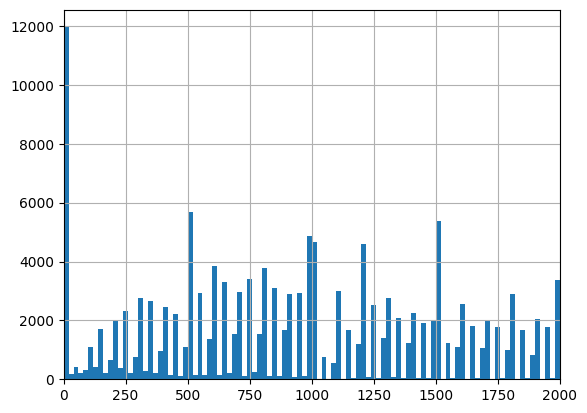

In [11]:
plt.xlim([0, 2000])
data['Price'].hist(bins=1000);

**На примере отфильтрованных данных мы видим, что существует в данных большое кол-во автомобилей, новее 2010 года выпуска с ценой ниже 500 евро, что, конечно, является ошибкой и неверными данными. В исходных данных, очевидно, большое кол-во ошибочных данных, которые необходимо отбросить.**

In [12]:
data = data[data['Price'] > 500]
data.shape[0] / initial_rows

0.8791993656329984

**Осталось почти 88% данных после удаления.**

**Посмотрим, сколько процентов от всех данных содержат нулевое значение месяца.**

In [13]:
data[data['RegistrationMonth'] == 0]['RegistrationMonth'].count() / data['RegistrationMonth'].count()

0.07543627090682081

**Порядка 7.5% всех данных содержат нулевое значение месяца. Скорее всего в данном случае нулевое значение аналогично пропуску в данных.**

**С точки зрения здравого смысла, на стоимость авто больше влияет год выпуска, чем месяц. В редких исключительных случаях в один и тот же год выпуска, называемый переходным, могут быть выпущен рестайлинг конкретной модели авто. Поэтому исключим из данных этот признак, оставив только признак, отвечающий за год выпуска авто.**

In [14]:
data = data.drop(['RegistrationMonth'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


**Посмотрим теперь внимательнее на значения признака `Power` и отсечем от данных аномальные значения.**

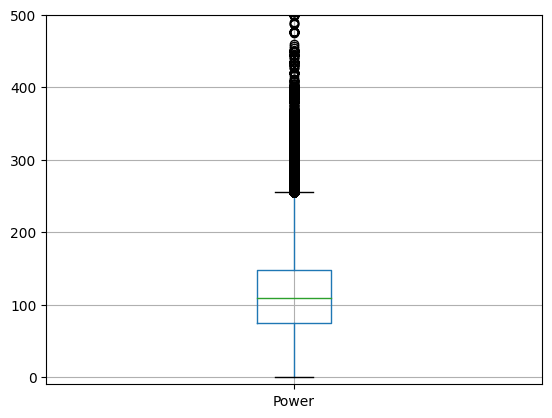

In [15]:
plt.ylim([-10, 500])
data.boxplot(['Power']);

**Из интернета определил, что самый маломощный автомобиль имеет 5 л.с., соответственно, все, что ниже 5 л.с. - является аномальными значениями и их необходимо отбросить. При этом предварительно оценим, какая часть данных из этого фильтра соответствует значению признака `Power` равное нулю.**

In [16]:
data[(0 == data['Power'])].shape[0] / data[(5 > data['Power'])].shape[0]

0.9978021978021978

**Почти 99.8% процентов отфильтрованных данных по значению признака `Power` меньше 5 соответствует значению 0.**

**Оценим теперь, какой процент данных имеет нулевое значение данного признака от всех данных.**

In [17]:
data[(0 == data['Power'])].shape[0] / data.shape[0]

0.08743071180282513

**Порядка 8.7%. Можно считать эти данные пропусками, и чтобы не потерять такой большой процент данных, заполним эти пропуски медианным значением для каждой модели авто ниже, в части работы, где работаем с пропусками.**

**Предварительно удалим данные, где значение данного признака менее 5, но больше 0. С нулевыми значениями будет проведена работа ниже.**

In [18]:
data = data[(data['Power'] >= 5) | ((data['Power'] == 0))]
data.shape[0] / initial_rows

0.8790300505969766

**Осталось почти 88% данных после удаления.**

**Проверим на процент полных дубликатов в отфильтрованных предварительными шагами выше данных.**

In [19]:
data.duplicated().sum() / data.shape[0]

0.1282692511420509

**Удалим полные дубликаты.**

In [20]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [21]:
data.shape[0] / initial_rows

0.7662775242755433

**Остаток данных - 76.6% от первоначального количества.**.

**Проверим теперь на неявные дубликаты некоторые признаки.**

In [22]:
for column in ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']:
    print(data.groupby([column])[column].count())
    print()

VehicleType
bus            24759
convertible    17380
coupe          13151
other           2547
sedan          71353
small          55832
suv            10423
wagon          51473
Name: VehicleType, dtype: int64

Gearbox
auto       56061
manual    204401
Name: Gearbox, dtype: int64

FuelType
cng            489
electric        77
gasoline     81998
hybrid         212
lpg           4572
other          106
petrol      162709
Name: FuelType, dtype: int64

Brand
alfa_romeo         1846
audi              23599
bmw               29454
chevrolet          1535
chrysler           1152
citroen            4224
dacia               817
daewoo              375
daihatsu            537
fiat               6987
ford              18049
honda              2317
hyundai            3068
jaguar              453
jeep                594
kia                2102
lada                188
lancia              337
land_rover          488
mazda              4420
mercedes_benz     27314
mini               2812
mitsubishi

**Среди указанных выше признаков неявных дубликатов не выявлено.**

**Проверка на кол-во пропусков в каждом признаке в долях от общего количества объектов.**

In [23]:
data.isna().mean()

Price               0.000000
VehicleType         0.090692
RegistrationYear    0.000000
Gearbox             0.040815
Power               0.000000
Model               0.048644
Kilometer           0.000000
FuelType            0.078742
Brand               0.000000
Repaired            0.177801
dtype: float64

**Самое большое количество пропусков в признаке `Repaired` - почти 17% от общего количества объектов. Этот признак является важным, т.к. влияет на стоимость авто.**

**На втором месте - пропуски в признаке `VehicleType`, их 9%.**

**Есть порядка 4% пропусков в признаке `Gearbox`.**

**Как ранее было отмечено, есть пропуски в признаке `Power`, которые выражаются нулевыми значениями.**

**Что касается пропусков в признаке `Model` - эти данные невозможно восстановить по остальным признакам, поэтому их можно удалить.**

**Есть порядка 8% пропусков в признаке `FuelType`.**

**Удалим ниже пропуски в признаке `Model`.**

In [24]:
data = data.dropna(subset=['Model'])
data.shape[0] / initial_rows

0.7290028190953498

**Осталось почти 73% данных от исходных.**

**Заменим пропуски в типе кузова автомобиля самым многочисленным значением для данной модели данного бренда среди данных.**

In [25]:
val = data.groupby(['Model', 'Brand'])['VehicleType'].transform(lambda x: x.mode().iat[0])
data['VehicleType'] = data['VehicleType'].fillna(val)
data['VehicleType'].isna().sum()

0

**Поступим аналогичным образом для заполнения пропусков в признаках тип топлива и тип КПП.**

In [26]:
val = data.groupby(['Model', 'Brand'])['FuelType'].transform(lambda x: x.mode().iat[0])
data['FuelType'] = data['FuelType'].fillna(val)

val = data.groupby(['Model', 'Brand'])['Gearbox'].transform(lambda x: x.mode().iat[0])
data['Gearbox'] = data['Gearbox'].fillna(val)

data.isna().mean()

Price               0.000000
VehicleType         0.000000
RegistrationYear    0.000000
Gearbox             0.000000
Power               0.000000
Model               0.000000
Kilometer           0.000000
FuelType            0.000000
Brand               0.000000
Repaired            0.166365
dtype: float64

**Для заполнения пропусков в признаке `Repaired` аналогичным образом предварительно удалим те строки с пропущенными значениями, где модель уникальна и нет возможности опереться на какую-либо статистику по ремонтам данной модели.**

In [27]:
#создаем новый дф, группируя исходный по кол-ву моделей, где при этом есть пропуск в Repaired
df_temp = data[data['Repaired'].isna()]['Model'].value_counts(ascending=True).to_frame()

#создаем список из тех моделей, которые уникальны
temp_list = df_temp[df_temp['Model'] == 1].index.to_list()

#выведем данные строки из исходного дф
df_chosen_rows = data[(data['Repaired'].isna()) & (data['Model'].isin(temp_list))].copy()
df_chosen_rows

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
27949,1050,small,1998,manual,103,rangerover,150000,petrol,rover,NaN
164289,8000,wagon,2012,manual,90,lodgy,125000,gasoline,dacia,NaN
234296,3800,wagon,1978,manual,0,serie_1,30000,gasoline,land_rover,NaN
309856,18555,suv,2010,manual,163,amarok,70000,gasoline,volkswagen,NaN


In [28]:
#удалим данные строки из исходного дф через индекс
data = data.drop(df_chosen_rows.index)
data[(data['Repaired'].isna()) & (data['Model'].isin(temp_list))]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


**Необходимые строки удалили. Теперь заполним пропуски в признаке `Repair` значением, наиболее часто встречающимся для данной модели авто.**

In [29]:
val = data.groupby(['Model', 'Brand'])['Repaired'].transform(lambda x: x.mode().iat[0])
data['Repaired'] = data['Repaired'].fillna(val)
data.isna().mean()

Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
dtype: float64

**Заменим пропуски в признаке мощность автомобиля, которые выражаются нулевым значением в данных, медианным значением для данной модели данного бренда среди данных.**

In [30]:
data.loc[data['Power'] == 0, 'Power'] = data.groupby(['Model', 'Brand'])['Power'].transform('median')
data[data['Power'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


In [31]:
data.isna().mean()

Price               0.0
VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
dtype: float64

**Пропусков в данных больше нет.**

In [32]:
data.shape[0] / initial_rows

0.7289915314262816

**Итого, потери данных после предобработки составили около 27%.**

**Изменим тип признака `Power` на целочисленный.**

In [33]:
data['Power'] = data['Power'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258332 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             258332 non-null  int64 
 1   VehicleType       258332 non-null  object
 2   RegistrationYear  258332 non-null  int64 
 3   Gearbox           258332 non-null  object
 4   Power             258332 non-null  int64 
 5   Model             258332 non-null  object
 6   Kilometer         258332 non-null  int64 
 7   FuelType          258332 non-null  object
 8   Brand             258332 non-null  object
 9   Repaired          258332 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


**Для упрощения впоследствии работы моделей переведем категориальный признак `RegistrationYear` в числовой - возраст авто или `Age`.**

In [34]:
data['Age'] = datetime.now().year - data['RegistrationYear']
data = data.drop(['RegistrationYear'], axis = 1)
data.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
2,9800,suv,auto,163,grand,125000,gasoline,jeep,no,19
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,22
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,15
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes,28
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no,19


**После предобработки проверим корреляцию признаков.**

In [35]:
data.corr()

<ipython-input-35-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,Price,Power,Kilometer,Age
Price,1.000000,0.127155,-0.372874,-0.415412
Power,0.127155,1.000000,0.034756,-0.013039
Kilometer,-0.372874,0.034756,1.000000,0.259965
Age,-0.415412,-0.013039,0.259965,1.000000


**Видим небольшую обратную корреляцию между целевым признаком и возрастом авто. Она была бы еще выше, если бы можно было получить более корректные данные с точки зрения логики, а как мы помним, выше мы обнаружили заниженную стоимость автомобилей с достаточно новым годом выпуска, что несоответствует реальности.**

## Обучение моделей

### Разделение данных на выборки

**Разобъем наш исходный датасет на выборки - тренировочную и тестовую. Отдельную валидационную выборку создавать не будем, т.к. далее воспользуемся GridSearchCV с кросс-валидацией.**

**Т.к. в наших данных есть категориальные признаки, то для дальнейшей работы простых моделей с ними, необходимо их закодировать. Кодировать категориальные признаки будем методом OneHotEncoder для линейной регрессии и методом OrdinalEncoder для регрессии решающим деревом. Для LightGBM отдельным образом признаки кодировать не нужно.**

In [36]:
#делим исходный датасет на признаки и целевой признак
target = data['Price']
features = data.drop('Price', axis=1)

#разбиваем признаки и целевые признаки на тренировочную и тестовую выборки в соотношении 75/25
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=1)

#выделяем списки числовых признаков и категориальных признаков
num_cols = ['Power', 'Kilometer', 'Age']
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


features_train_linreg = features_train.copy()
features_test_linreg = features_test.copy()
ct_linreg = ColumnTransformer([
    ("scaling", StandardScaler(), num_cols),
    ("onehot", OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)])
ct_linreg.fit(features_train_linreg)
features_train_linreg = ct_linreg.transform(features_train_linreg)
features_test_linreg = ct_linreg.transform(features_test_linreg)

features_train_tree = features_train.copy()
features_test_tree = features_test.copy()
ct_tree = ColumnTransformer([
    ("scaling", StandardScaler(), num_cols),
    ("onehot", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), cat_cols)])
ct_tree.fit(features_train_tree)
features_train_tree = ct_tree.transform(features_train_tree)
features_test_tree = ct_tree.transform(features_test_tree)

features_train_lgb = features_train.copy()
features_test_lgb = features_test.copy()
features_train_lgb[cat_cols] = features_train_lgb[cat_cols].astype('category')
features_test_lgb[cat_cols] = features_test_lgb[cat_cols].astype('category')

print(features_train_linreg.shape)
print(features_test_linreg.shape)

print(features_train_tree.shape)
print(features_test_tree.shape)

print(features_train_lgb.shape)
print(features_test_lgb.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(193749, 310)
(64583, 310)
(193749, 9)
(64583, 9)
(193749, 9)
(64583, 9)


**Для текущей задачи выберем три модели для сравнения - линейная регрессия, регрессия решающего дерева и LightGBM. Для поиска набора гиперпараметров, дающих наилучший результат метрики RMSE, будем использовать инструмент GridSearchCV, который в своем механизме также использует кросс-валидацию.**

### Линейная регрессия

In [37]:
model_linreg = LinearRegression()
cv_linreg = cross_validate(
                model_linreg,
                features_train_linreg,
                target_train,
                scoring='neg_root_mean_squared_error',
                cv=3,
                n_jobs=-1)
lin_reg_rmse_train = round(-1*max(cv_linreg['test_score']), 3)
# lin_reg_fit_time_train = round(
#     cv_linreg['fit_time'][list(cv_linreg['test_score']).index(max(cv_linreg['test_score']))], 3)
# lin_reg_score_time_train = round(
#     cv_linreg['score_time'][list(cv_linreg['test_score']).index(max(cv_linreg['test_score']))], 3)
lin_reg_fit_time_train = round(cv_linreg['fit_time'].mean())
lin_reg_score_time_train = round(cv_linreg['score_time'].mean())
print('RMSE для LinReg на тренировочной выборке =', lin_reg_rmse_train)
print('Время обучения LinReg на тренировочной выборке =', lin_reg_fit_time_train)
print('Время предсказания LinReg на тренировочной выборке =', lin_reg_score_time_train)

RMSE для LinReg на тренировочной выборке = 26482508149.846
Время обучения LinReg на тренировочной выборке = 9
Время предсказания LinReg на тренировочной выборке = 0


### Регрессия решающим деревом

In [38]:
model_tree = DecisionTreeRegressor(random_state=1)

param_tree = {'max_depth':range(1,10,2),
              'criterion':['friedman_mse'],
              'min_samples_split':range(2,10,2),
              'max_depth': range(1,10,2)}
gridsearch_tree = GridSearchCV(
    estimator=model_tree,
    param_grid=param_tree,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1)
gridsearch_tree.fit(features_train_tree, target_train)
#метрика в gridsearchCV - отрицательное значение RMSE, чтобы получить RMSE необходимо умножить на -1

tree_rmse_train = round((-1 * gridsearch_tree.best_score_), 3)
tree_fit_time_train = round(
    pd.DataFrame(gridsearch_tree.cv_results_).iloc[gridsearch_tree.best_index_]['mean_fit_time'], 3)
tree_score_time_train = round(
    pd.DataFrame(gridsearch_tree.cv_results_).iloc[gridsearch_tree.best_index_]['mean_score_time'], 3)
print('Лучшее значение метрики RMSE для модели DecTreeReg на тренировочной выборке =', tree_rmse_train)
print('Время обучения модели DecTreeReg с лучшим score на тренировочной выборке =', tree_fit_time_train)
print('Время предсказания DecTreeReg с лучшим score на тренировочной выборке =', tree_score_time_train)
print('Параметры модели DecTreeReg с лучшим score на тренировочной выборке =', gridsearch_tree.best_params_)

Лучшее значение метрики RMSE для модели DecTreeReg на тренировочной выборке = 2105.16
Время обучения модели DecTreeReg с лучшим score на тренировочной выборке = 0.366
Время предсказания DecTreeReg с лучшим score на тренировочной выборке = 0.009
Параметры модел DecTreeReg с лучшим score на тренировочной выборке = {'criterion': 'friedman_mse', 'max_depth': 9, 'min_samples_split': 8}


### Модель градиентного бустинга LightGBM

In [40]:
model_lgb = lgb.LGBMRegressor(num_threads=4, random_state=1)

param_lgb = {'learning_rate': [0.3, 0.1],
             'n_estimators': [50, 100],
             'verbose': [-1]}
gridsearch_lgb = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_lgb,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=-1)
gridsearch_lgb.fit(features_train_lgb, target_train)
#метрика в gridsearchCV - отрицательное значение RMSE, чтобы получить RMSE необходимо умножить на -1

lgb_rmse_train = round(-1 * gridsearch_lgb.best_score_, 3)
lgb_fit_time_train = round(
    pd.DataFrame(gridsearch_lgb.cv_results_).iloc[gridsearch_lgb.best_index_]['mean_fit_time'], 3)
lgb_score_time_train = round(
    pd.DataFrame(gridsearch_lgb.cv_results_).iloc[gridsearch_lgb.best_index_]['mean_score_time'], 3)
print('Лучшее значение метрики RMSE для модели LGBM на тренировочной выборке =', lgb_rmse_train)
print('Время обучения модели LGBM с лучшим score на тренировочной выборке =', lgb_fit_time_train)
print('Время предсказания LGBM с лучшим score на тренировочной выборке =', lgb_score_time_train)
print('Параметры модели LGBM с лучшим score на тренировочной выборке =', gridsearch_lgb.best_params_)

Лучшее значение метрики RMSE для модели LGBM на тренировочной выборке = 1664.048
Время обучения модели LGBM с лучшим score на тренировочной выборке = 1.043
Время предсказания LGBM с лучшим score на тренировочной выборке = 0.267
Параметры модели LGBM с лучшим score на тренировочной выборке = {'learning_rate': 0.3, 'n_estimators': 100, 'verbose': -1}


## Анализ моделей

In [ ]:
try:
    data_models = [[lin_reg_fit_time_train, tree_fit_time_train, lgb_fit_time_train],
                   [lin_reg_score_time_train, tree_score_time_train, lgb_score_time_train],
                   [lin_reg_rmse_train, tree_rmse_train, lgb_rmse_train]]
except:
    data_models = [[lin_reg_fit_time_train, tree_fit_time_train, 'NaN'],
                   [lin_reg_score_time_train, tree_score_time_train, 'NaN'],
                   [lin_reg_rmse_train, tree_rmse_train, 'NaN']]

pd.DataFrame(data_models,
             columns=['lin_reg', 'dec_tree_reg', 'lgbm_reg'],
             index=['fit_time', 'score_time', 'train_rmse'])

,lin_reg,dec_tree_reg,lgbm_reg
fit_time,1.209900e+01,0.233,1.751
score_time,2.100000e-02,0.007,0.517
train_rmse,1.220907e+10,2105.160,1664.048


**ВЫВОД**

**Лучшее значение метрики RMSE получено на модели LGBM, лучшее время обучения и предсказания показала модель регрессии решающего дерева.**

**Т.к. критерии, которые важны заказчику это:**

**- качество предсказания;**

**- время обучения модели;**

**- время предсказания модели.**

**То по совокупности факторов лучше выбрать модел LGBM, т.к качество предсказания у нее сильно выше, а время обучения хоть и больше, чем у другой модели, но достаточно адекватно.**

**Проверим теперь лучшую по score модель LGBM на тестовой выборке.**

In [ ]:
start_predict_lgb = time.time()
predict_lgb = gridsearch_lgb.best_estimator_.predict(features_test_lgb)
end_predict_lgb = time.time()
print('RMSE для LGBM на тестовой выборке =',
      round(mean_squared_error(target_test, predict_lgb, squared=False),3))
print('Время предсказания LGBM на тестовой выборке =',
      round(end_predict_lgb - start_predict_lgb, 3))

RMSE для LGBM на тестовой выборке = 1654.014
Время предсказания LGBM на тестовой выборке = 0.412


## Проверка моделей на адекватность

**Проверим выбранные модели на адекватность с помощью Dummy Model из класса sklearn, предварительно импортировав ее в первом пункте.**

**Проверка состоит в том, чтобы качество выбранной выше обученной модели было выше, чем качество модели Dummy, которая предсказывает результат не опираясь на признаки тренировочной выборки.**

In [ ]:
model_dummy = DummyRegressor()
parameters_dummy = {'strategy':['mean', 'median', 'constant'],
                            'constant':(500,20000,500)}
gridsearch_dummy = GridSearchCV(
    estimator=model_dummy,
    param_grid=parameters_dummy,
    scoring='neg_root_mean_squared_error',
    cv=5, n_jobs=-1)
gridsearch_dummy.fit(features_train, target_train)
print('Лучшее значение метрики RMSE для Dummy-модели на тренировочной выборке =',
      (-1 * gridsearch_dummy.best_score_))

Лучшее значение метрики RMSE для Dummy-модели на тренировочной выборке = 4578.517038689584


In [ ]:
predict_dummy = gridsearch_dummy.best_estimator_.predict(features_test)
print('Лучшее значение метрики RMSE для Dummy-модели на тестовой выборке =',
      mean_squared_error(target_test, predict_dummy, squared=False))

Лучшее значение метрики RMSE для Dummy-модели на тестовой выборке = 4571.226809875121


**ВЫВОД**

**В итоге с помощью Dummy модели удалось получить наилучшее качество модели с RMSE равным 4571 на тестовой выборке, что значительно ниже наилучшего результата выбранных и обученных моделей линейной регрессии, регрессии решающего дерева и LightGBM. Что доказывает адекватность найденной и выбранной нами модели.**